# Le voyageur de commerce

Ce projet est inspiré du Chapitre 4 du livre “The Cross-Entropy Method” de
Rubinstein et Kroese.

Le problème du voyageur de commerce (en anglais, TSP, travelling salesman
problem) revient à minimiser le trajet effectué entre M villes, sous la contrainte
de passer par chaque ville exactement une fois. Soit D la matrice telle que Dij
est la distance entre la ville i et la ville j; noter que Dii = 0 et D est symétrique.

1) Rappeler (ou retrouver!) la méthode permettant de simuler efficacement
N vecteurs selon la loi Multinomiale définie par le vecteur de probabilité
p = (p1, . . . , pM). La mettre en œuvre.

In [1]:
import matplotlib.pyplot as plt
import seaborn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


(array([ 1012.,   991.,   962.,  1036.,  1031.,   996.,   958.,  1036.,
         1005.,   973.]),
 array([  1.14534885e-04,   1.00094302e-01,   2.00074070e-01,
          3.00053837e-01,   4.00033604e-01,   5.00013371e-01,
          5.99993139e-01,   6.99972906e-01,   7.99952673e-01,
          8.99932441e-01,   9.99912208e-01]),
 <a list of 10 Patch objects>)

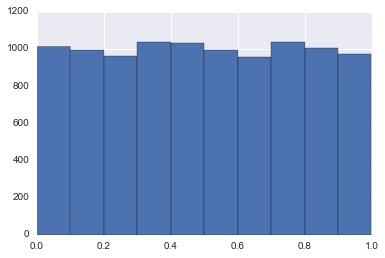

In [2]:
from scipy.stats import expon
def sorted_uniforms(N):
    """
    Returns N sorted uniforms
    """
    E = expon.rvs(size=N+1)
    V = [sum(E[:i+1]) for i in range(N+1)]
    return V[:-1]/V[-1]


plt.hist(sorted_uniforms(10000))

In [3]:
def multinomial(P, N):    
    su = sorted_uniforms(N)
    j = 0
    s = P[0]
    A = []
    for n in range(N):
        while su[n] > s:
            j += 1
            s += P[j]
        A += [j]
    return A

(array([ 1255.,     0.,  1292.,     0.,     0.,  1216.,     0.,   642.,
            0.,   595.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

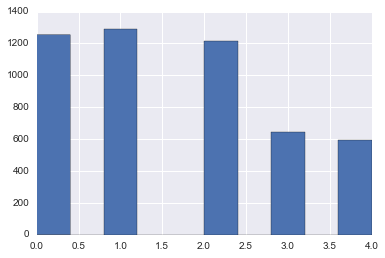

In [4]:
P = [1/4, 1/4, 1/4, 1/8, 1/8]
plt.hist(multinomial(P, 5000))

In [5]:
multinomial(P, 10)

[0, 0, 1, 1, 2, 2, 2, 4, 4, 4]

2) Utiliser l’algorithme CE vu en cours pour résoudre le problème TSP. Pour
ce faire, proposer une famille paramétrique de lois pour la simulation de
trajets. Programmer cet algorithme, et le tester sur quelques exemples.

In [412]:
# Random distance matrix
number_of_cities = 15
C = np.reshape(np.random.poisson(number_of_cities, number_of_cities**2), (number_of_cities,number_of_cities))
for i in range(len(C)):
    C[i,i] = 0
    for j in range(len(C)):
        C[i,j] = C[j, i]
C

array([[ 0, 10, 17, 15, 18, 15, 15, 16,  7, 14, 13, 12, 19, 25,  9],
       [10,  0, 17, 15, 11,  8, 10, 12, 14, 19, 16, 14, 13, 18, 12],
       [17, 17,  0, 19, 13, 13, 16, 16, 15, 12, 16, 11, 13, 10,  9],
       [15, 15, 19,  0, 15, 11, 20, 15, 16, 12, 19, 21, 19,  9, 19],
       [18, 11, 13, 15,  0, 17, 18, 20, 11, 11, 19, 22, 11, 12,  9],
       [15,  8, 13, 11, 17,  0, 13, 17, 14, 10, 12,  7, 12, 14, 15],
       [15, 10, 16, 20, 18, 13,  0,  9, 16, 18, 13, 12, 14, 13, 15],
       [16, 12, 16, 15, 20, 17,  9,  0, 15, 19, 13, 15, 21, 13, 14],
       [ 7, 14, 15, 16, 11, 14, 16, 15,  0, 17, 12, 17, 17, 13, 10],
       [14, 19, 12, 12, 11, 10, 18, 19, 17,  0, 10,  7, 14, 15, 10],
       [13, 16, 16, 19, 19, 12, 13, 13, 12, 10,  0, 11,  9, 20,  8],
       [12, 14, 11, 21, 22,  7, 12, 15, 17,  7, 11,  0, 20, 10, 17],
       [19, 13, 13, 19, 11, 12, 14, 21, 17, 14,  9, 20,  0, 15, 13],
       [25, 18, 10,  9, 12, 14, 13, 13, 13, 15, 20, 10, 15,  0,  6],
       [ 9, 12,  9, 19,  9, 15, 15

In [413]:
from sklearn.preprocessing import normalize
P = np.reshape(np.random.rand(number_of_cities**2), (number_of_cities,number_of_cities))
for i in range(number_of_cities): 
    P[i,i] = 0
P = P/P.sum(axis=1)[:,None]
P

array([[  0.00000000e+00,   8.14901089e-02,   6.84080294e-02,
          1.31225653e-01,   2.11152474e-02,   1.34379706e-01,
          7.30209827e-02,   1.49993966e-01,   3.68515975e-03,
          2.55710149e-02,   6.65141065e-02,   2.17133914e-02,
          1.16829885e-01,   2.95712970e-02,   7.64814532e-02],
       [  8.59739939e-02,   0.00000000e+00,   5.47039946e-02,
          1.22021032e-01,   1.11211724e-01,   8.00309376e-02,
          9.21018742e-02,   5.94167473e-02,   1.79031022e-02,
          1.26119054e-01,   5.32433316e-02,   6.69011670e-02,
          5.98923319e-03,   1.58426574e-02,   1.08541151e-01],
       [  8.07525229e-02,   3.55062890e-02,   0.00000000e+00,
          1.68767726e-02,   1.05038104e-04,   6.36930459e-02,
          9.06384548e-02,   6.24316621e-02,   1.35817028e-01,
          7.16300584e-02,   1.35016312e-01,   8.12771286e-02,
          2.81100284e-02,   1.07169740e-01,   9.09759192e-02],
       [  1.19277536e-01,   1.55647088e-02,   6.46610484e-02,
     

In [414]:
def trajectory(P):
    P_ = P.copy()
    X = np.zeros(len(P), np.int8)
    for i in range(len(P)-1):
        P_[:,X[i]] = 0
        P_ = P_/P_.sum(axis=1)[:,None]
        X[i+1] = multinomial(P_[X[i],:], 1)[0]
    return X
X = trajectory(P)

In [415]:
def multi_trajectories(P, N):
    return [trajectory(P) for i in range(N)]

In [416]:
def S(X, C):
    return sum([C[X[i], X[i+1]] for i in range(len(X)-1)])

S(X,C)

213

In [417]:
def init_P(size):
    P = np.ones((size, size))/(size-1)
    for i in range(size):
        P[i,i]=0
    return P

In [429]:
def CE(C, n, rho=0.5):
    degree = len(C)
    
    P = init_P(degree)
    
    trajectories = multi_trajectories(P, n)
        
    length = [S(trajectory, C) for trajectory in trajectories]
    
    gamma = np.percentile(length, rho, interpolation='lower')
    
    trajectories_sample = [traj for traj in trajectories if S(traj, C) <= gamma]
        
    P = np.zeros(P.shape)
    
    couples = [(traj[-1], traj[0]) + [(traj[i], traj[i+1]) for i in range(degree-1)] for traj in trajectories_sample]
    
    for i in range(degree):
        for j in range(degree):
            P[i,j] = sum([1 for couple in couples if (i,j) in couple])/len(trajectories_sample)
    return P, gamma

In [430]:
CE(C, 1000)

(array([[ 0.        ,  0.16666667,  0.        ,  0.16666667,  0.        ,
          0.        ,  0.16666667,  0.16666667,  0.        ,  0.16666667,
          0.        ,  0.16666667,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.16666667,
          0.16666667,  0.16666667,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.16666667,  0.16666667,  0.16666667],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.33333333,  0.16666667,  0.16666667,  0.16666667,
          0.        ,  0.        ,  0.        ,  0.        ,  0.16666667],
        [ 0.        ,  0.33333333,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.16666667,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.16666667,  0.        ,  0.        ,
          0.        ,  0.        ,

3) Concernant l’estimation bayésienne de vecteurs de probabilité d’une loi
multinomiale, retrouver le fait que la famille des lois de Dirichlet est
conjuguée pour ce modèle. Expliquer comment en pratique vous pouvez
utiliser cette propriété pour améliorer votre algorithme.

4) Bonus: en fonction du temps disponible, vous pouvez tester votre algorithme
sur de “gros” problèmes (par ex. trajet optimal du tour de France
en se basant sur la liste des villes de l’année dernière), ou comparer à
d’autres algorithmes que vous trouverez dans la littérature.

In [322]:
l = [1,2]
percentile(l, 0.5, interpolation='lower')

1